# Задача

Необходимо предсказать стоимость автомобиля по техническому состоянию

# Загрузка библиотек и датасета

In [1]:
import pandas as pd
from pandas import Series
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from itertools import combinations
from scipy.stats import ttest_ind
from sklearn.base import clone

from sklearn.utils import shuffle 
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import ExtraTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor

from tqdm.notebook import tqdm
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [2]:
DIR_TRAIN  = '../input/auto-ru-scrap/' # подключил к ноутбуку внешний датасет
DIR_TEST   = '../input/sf-dst-car-price-prediction/'

In [3]:
train = pd.read_csv(DIR_TRAIN+'auto_ru_update.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

# Определение функций

In [4]:
def get_nan():
    ''' Создание датафрейма со всеми пропусками
    '''
    return(pd.DataFrame(df.isna().sum(), columns=['NaN']))

def numerical_check(col):
    ''' Построение гистограммы и вывод основных статистических данных цифровых признаков 
    '''
    plt.figure()
    sns.distplot(df[col], kde = False, rug=False)
    plt.title(col)
    plt.show()
    display(df[col].describe())
    

def categorical_check(col):
    ''' Вывод основных статистических данных категориальных признаков
    '''
    df[col].value_counts().plot.barh()
    plt.title(col)
    display(df[col].describe())
    

def outliers(col):
    ''' Поиск выбросов в данных. Выводятся границы и количество выбросов
    '''
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    l_side = perc25 - 1.5*IQR
    r_side = perc75 + 1.5*IQR
    drop = df[(df[col] <= l_side) | (df[col] >= r_side)]
    print('col: {}'.format(col),
          '\nleft: {}'.format(l_side),
          '\nright: {}'.format(r_side),
          '\nout: {}'.format(len(drop)))
    

def engine_to_liter(row):
    row = str(row)
    liter = re.findall('\d\.\d', row)
    if liter == []:
        return None
    return float(liter[0])


def get_pop_100(data):
    ''' Проверка на популярную модель.
    '''
    for i in top_100:
        if i == data:
            return 1 
    return 0


def get_pop_10(data):
    ''' Проверка на популярную марку.
    '''
    for i in top_10:
        if i == data:
            return 1 
    return 0


def get_corr(dataframe, col):
    ''' Построение тепловой карты коррелирующих признаков.
    '''
    df = dataframe
    plt.figure(figsize=(6, 5), dpi=300)
    sns.heatmap(df[col].corr(), cmap='RdYlGn',
                center=0, annot=True)
    plt.title('Correlation', fontsize=8)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.show()
    

def get_stat_dif(d_column, d_df):
    ''' Тест стьюдента
    '''
    cols = d_df.loc[:, d_column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        ttest = ttest_ind(d_df.loc[d_df.loc[:, d_column] == comb[0], 'price'].dropna(),
                          d_df.loc[d_df.loc[:, d_column] == comb[1], 'price'].dropna()).pvalue
        if  ttest<= 0.05/len(combinations_all): # Учли поправку Бонферони
            return(d_column)
            break    
    

def model_metrics(model, name):
    '''Метрика модели
    '''
    model = model
    y_pred = np.exp(model.predict(X_test))
    mape = np.round(np.mean(np.abs((y_pred-y_test)/y_test))*100, 2)
    return pd.DataFrame(columns=[name], index=['MAPE'], data=[mape])

# Парсинг

Парсинг реализован по ссылке:  
В общем, у меня сглючил github и локальный ноутбук потерся, при этом я имею данные от 20 декабря 2020 года, но воставноваить сам ноутбук к сдачи проекта я не успею. Отныне буду комитить каждый день, чтобы не повторилась такая ситуация

# Обработка данных

In [5]:
#Посмотрим на полученные данные с парсинга, а также на данные тестовой сборки.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76578 entries, 0 to 76577
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              76576 non-null  object 
 1   brand                 76578 non-null  object 
 2   color                 76578 non-null  object 
 3   fuelType              76578 non-null  object 
 4   modelDate             76576 non-null  float64
 5   name                  76576 non-null  object 
 6   numberOfDoors         76576 non-null  float64
 7   productionDate        76578 non-null  int64  
 8   vehicleConfiguration  76576 non-null  object 
 9   vehicleTransmission   76576 non-null  object 
 10  engineDisplacement    76576 non-null  object 
 11  enginePower           76576 non-null  float64
 12  description           73838 non-null  object 
 13  mileage               76578 non-null  int64  
 14  Комплектация          76578 non-null  object 
 15  Привод             

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [8]:
# Видим, что есть расхождения по признакам, в первую очередь сопоставим признаки и сформируем единый датасет
train_col_list = list(train.columns)
test_col_list = list(test.columns)

general=list(set(train_col_list) & set(test_col_list))
print('Общие признаки:\n', general)

other=list(set(test_col_list) - set(train_col_list))
print('\nПризнаки не вошедшие в test:\n', other)

other=list(set(train_col_list) - set(test_col_list))
print('\nПризнаки не вошедшие в train:\n', other)

Общие признаки:
 ['bodyType', 'fuelType', 'color', 'Владение', 'Привод', 'modelDate', 'Таможня', 'numberOfDoors', 'enginePower', 'brand', 'productionDate', 'description', 'name', 'Состояние', 'vehicleTransmission', 'Руль', 'vehicleConfiguration', 'engineDisplacement', 'mileage', 'ПТС', 'Владельцы']

Признаки не вошедшие в test:
 ['image', 'equipment_dict', 'complectation_dict', 'model_name', 'priceCurrency', 'model_info', 'car_url', 'sell_id', 'super_gen', 'parsing_unixtime', 'vendor']

Признаки не вошедшие в train:
 ['price', 'start_date', 'Комплектация', 'model', 'hidden']


In [9]:
# сопоставим признаки
test.car_url
# признак показывает ссылку на обьявление, можно удалить

0        https://auto.ru/cars/used/sale/skoda/octavia/1...
1        https://auto.ru/cars/used/sale/skoda/octavia/1...
2        https://auto.ru/cars/used/sale/skoda/superb/11...
3        https://auto.ru/cars/used/sale/skoda/octavia/1...
4        https://auto.ru/cars/used/sale/skoda/octavia/1...
                               ...                        
34681    https://auto.ru/cars/used/sale/bmw/3er/1101369...
34682    https://auto.ru/cars/used/sale/bmw/5er/1101369...
34683    https://auto.ru/cars/used/sale/bmw/5er/1101364...
34684    https://auto.ru/cars/used/sale/bmw/x1/11013625...
34685    https://auto.ru/cars/used/sale/bmw/x5/11012560...
Name: car_url, Length: 34686, dtype: object

In [10]:
test.parsing_unixtime
# признак показывает время парсинга обьявления, можно удалить

0        1603226273
1        1603226277
2        1603226280
3        1603226284
4        1603226288
            ...    
34681    1603707643
34682    1603707651
34683    1603707843
34684    1603707909
34685    1603710264
Name: parsing_unixtime, Length: 34686, dtype: int64

In [11]:
test.super_gen[0]
# признак содержит множество данны, быстрая проверка показала, что данные из этого признака есть в других признаках, можно удалить

'{"id":"10373605","displacement":1197,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":105,"power_kvt":77,"human_name":"1.2 AMT (105 л.с.)","acceleration":10.5,"clearance_min":155,"fuel_rate":5}'

In [12]:
test.vendor
# признак показывает принадлежность к стране, так как в парсинге таких данных нет, то можно удалить

0        EUROPEAN
1        EUROPEAN
2        EUROPEAN
3        EUROPEAN
4        EUROPEAN
           ...   
34681    EUROPEAN
34682    EUROPEAN
34683    EUROPEAN
34684    EUROPEAN
34685    EUROPEAN
Name: vendor, Length: 34686, dtype: object

In [13]:
test.equipment_dict[0]
# в признаке много полезных данных, но т.к. данные плохо спарсились, удалим этот признак

'{"engine-proof":true,"tinted-glass":true,"airbag-driver":true,"aux":true,"isofix":true,"electro-window-front":true,"ashtray-and-cigarette-lighter":true,"airbag-passenger":true,"computer":true,"high-beam-assist":true,"seat-transformation":true,"isofix-front":true,"wheel-power":true,"alarm":true,"lock":true,"door-sill-panel":true,"fabric-seats":true,"electro-mirrors":true,"airbag-rear-side":true,"electro-window-back":true,"steel-wheels":true,"ptf":true,"16-inch-wheels":true,"rain-sensor":true,"airbag-side":true,"audiosystem-cd":true,"dark-interior":true,"cooling-box":true,"condition":true,"abs":true,"power-child-locks-rear-doors":true,"front-seats-heat":true,"wheel-configuration2":true,"wheel-configuration1":true,"12v-socket":true,"park-assist-r":true}'

In [14]:
test.model_name
#призна соответствует признаку model из train

0        OCTAVIA
1        OCTAVIA
2         SUPERB
3        OCTAVIA
4        OCTAVIA
          ...   
34681        3ER
34682        5ER
34683        5ER
34684         X1
34685         X5
Name: model_name, Length: 34686, dtype: object

In [15]:
test.priceCurrency
# признак содержит валюту продажи, все данные соответствуют "RUB", можно удалить

0        RUB
1        RUB
2        RUB
3        RUB
4        RUB
        ... 
34681    RUB
34682    RUB
34683    RUB
34684    RUB
34685    RUB
Name: priceCurrency, Length: 34686, dtype: object

In [16]:
test.image
# признак содержит ссылку на изображение, можно удалить

0        https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...
1        https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...
2        https://avatars.mds.yandex.net/get-autoru-vos/...
3        https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...
4        https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...
                               ...                        
34681    https://autoru.naydex.net/nwI1K7152/b604fdsYg7...
34682    https://autoru.naydex.net/nwI1K7152/b604fdsYg7...
34683    https://avatars.mds.yandex.net/get-autoru-vos/...
34684    https://autoru.naydex.net/nwI1K7152/b604fdsYg7...
34685    https://avatars.mds.yandex.net/get-autoru-vos/...
Name: image, Length: 34686, dtype: object

In [17]:
test.sell_id
# Признак содержит id продавца, можно удалить

0        1100575026
1        1100549428
2        1100658222
3        1100937408
4        1101037972
            ...    
34681    1101369263
34682    1101369581
34683    1101364889
34684    1101362518
34685    1101256068
Name: sell_id, Length: 34686, dtype: int64

In [18]:
test.complectation_dict
# много пустых значений, похожая ситуация у данных с парсинга, удалим

0                                                      NaN
1                                                      NaN
2        {"id":"20026336","name":"Ambition","available_...
3        {"id":"20803582","name":"Ambition","available_...
4                                                      NaN
                               ...                        
34681                                                  NaN
34682                                                  NaN
34683                                                  NaN
34684    {"id":"6336008","name":"xDrive20d Локальная сб...
34685                                                  NaN
Name: complectation_dict, Length: 34686, dtype: object

In [19]:
test.model_info
# # признак содержит множество данны, быстрая проверка показала, что данные из этого признака есть в других признаках, можно удалить

0        {"code":"OCTAVIA","name":"Octavia","ru_name":"...
1        {"code":"OCTAVIA","name":"Octavia","ru_name":"...
2        {"code":"SUPERB","name":"Superb","ru_name":"Су...
3        {"code":"OCTAVIA","name":"Octavia","ru_name":"...
4        {"code":"OCTAVIA","name":"Octavia","ru_name":"...
                               ...                        
34681    {"code":"3ER","name":"3 серии","ru_name":"3 се...
34682    {"code":"5ER","name":"5 серии","ru_name":"5 се...
34683    {"code":"5ER","name":"5 серии","ru_name":"5 се...
34684    {"code":"X1","name":"X1","ru_name":"Х1","morph...
34685    {"code":"X5","name":"X5","ru_name":"Х5","morph...
Name: model_info, Length: 34686, dtype: object

In [20]:
train.start_date
# признак содержит дату публикации, можно удалить

0        2020-12-06T19:56:26Z
1        2020-12-04T15:04:02Z
2        2020-12-17T17:52:59Z
3        2020-12-17T14:09:19Z
4        2020-11-08T17:23:26Z
                 ...         
76573    2020-11-30T19:46:56Z
76574    2020-10-20T16:10:26Z
76575    2020-09-17T15:35:22Z
76576    2020-11-27T08:03:05Z
76577    2019-05-14T15:43:20Z
Name: start_date, Length: 76578, dtype: object

In [21]:
train.Комплектация
# Признак содержит много пустых значений, также пересекается с признаком equipment_dict из теста, но в силу отсутствия времени удалим

0                                              {'id': '0'}
1                                              {'id': '0'}
2                                              {'id': '0'}
3                                              {'id': '0'}
4                                              {'id': '0'}
                               ...                        
76573                                          {'id': '0'}
76574                                          {'id': '0'}
76575    {'id': '10408082', 'name': 'Luxury', 'availabl...
76576    {'id': '10408080', 'name': 'Comfort', 'availab...
76577    {'id': '10408081', 'name': 'Elegance', 'availa...
Name: Комплектация, Length: 76578, dtype: object

In [22]:
train.hidden
# пустой признак, можно удалить

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
76573   NaN
76574   NaN
76575   NaN
76576   NaN
76577   NaN
Name: hidden, Length: 76578, dtype: float64

In [23]:
train.price
# целевой признак

0         222222.0
1          90000.0
2         130000.0
3         165000.0
4         180000.0
           ...    
76573     977000.0
76574     949000.0
76575    1300000.0
76576    1000000.0
76577    1280000.0
Name: price, Length: 76578, dtype: float64

In [24]:
# удалим лишние признаки и согласуем форматы данных
test['model'] = test['model_name']
test.drop(['car_url', 'parsing_unixtime', 'super_gen', 'vendor', 'equipment_dict',
           'priceCurrency', 'image', 'sell_id', 'model_name', 'complectation_dict',
           'model_info'], axis=1, inplace=True)
train.drop(['hidden', 'Комплектация', 'start_date'], axis=1, inplace=True)

In [25]:
test['modelDate'] = test['modelDate'].astype('float64')
train['enginePower'] = train['enginePower'].astype('object')
test['numberOfDoors'] = test['numberOfDoors'].astype('float64')
train['Владельцы'] = train['Владельцы'].astype('object')
train['Состояние'] = train['Состояние'].astype('object')
train['Таможня'] = train['Таможня'].map({True: 'Растаможен', False:'Не растаможен'})

In [26]:
# соединим датасеты
train['Train'] = 1 # помечаем где у нас трейн
test['Train'] = 0 # помечаем где у нас тест
df = train.append(test, sort=False).reset_index(drop=True) # объединяем

# EDA

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111264 entries, 0 to 111263
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              111262 non-null  object 
 1   brand                 111264 non-null  object 
 2   color                 111264 non-null  object 
 3   fuelType              111264 non-null  object 
 4   modelDate             111262 non-null  float64
 5   name                  111262 non-null  object 
 6   numberOfDoors         111262 non-null  float64
 7   productionDate        111264 non-null  int64  
 8   vehicleConfiguration  111262 non-null  object 
 9   vehicleTransmission   111262 non-null  object 
 10  engineDisplacement    111262 non-null  object 
 11  enginePower           111262 non-null  object 
 12  description           108524 non-null  object 
 13  mileage               111264 non-null  int64  
 14  Привод                111262 non-null  object 
 15  

In [28]:
get_nan()

,NaN
bodyType,2
brand,0
color,0
fuelType,0
modelDate,2
name,2
numberOfDoors,2
productionDate,0
vehicleConfiguration,2
vehicleTransmission,2


Что мы имеем:  
**Описания полей датасета**
* bodyType - кузов автомобиля
* brand - марка автомобиля
* color - цвет автомобиля 
* fuelType - тип топлива 
* modelDate - дата выпуска модели 
* name - комбинация нескольких характеристик 
* numberOfDoors - кол-во дверей
* productionDate - дата производства авто
* vehicleConfiguration - комбинация нескольких характеристик
* vehicleTransmission - тип трансмиссии 
* engineDisplacement - объем двигателя в литрах
* enginePower - мощность двигателя (л.с.)
* description - дополнительные характеристики по комплектации авто
* mileage - пробег автомобиля (км.)
* Комплектация - дополнительные характеристики по комплектации авто
* Привод - привод автомобиля
* Руль - положение руля
* Состояние - нужен ли ремонт
* Владельцы - кол-во владельцев 
* ПТС - тип ПТС 
* Таможня - расстаможен ли автомобиль
* Владение - срок владения автомобилем
* price - цена указанная в объявлении
* start_date - дата размещения объявления на авто.ру
* model - название модели автомобиля 
* Train - сервисный для разделения train и test

## bodyType

count                111262
unique                  174
top       Внедорожник 5 дв.
freq                  33107
Name: bodyType, dtype: object

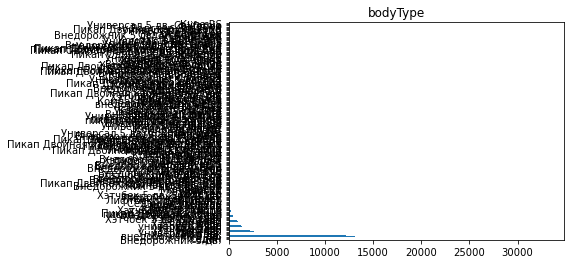

In [29]:
categorical_check('bodyType')

In [30]:
# Есть типы кузова которые начинаются с большой буквы, так и с маленькой, уровняем.
# Есть два пропуска, заполним самым популярным значением
df['bodyType'] = df['bodyType'].apply(lambda x: str(x).lower())
df['bodyType'].fillna('внедорожник 5 дв.', inplace=True)

In [31]:
df.bodyType.value_counts()

внедорожник 5 дв.              45335
седан                          34617
хэтчбек 5 дв.                   8177
лифтбек                         5260
универсал 5 дв.                 3855
                               ...  
седан t140                         1
седан 120                          1
универсал 5 дв. ardeo              1
седан latio                        1
универсал 5 дв. crossover 7        1
Name: bodyType, Length: 150, dtype: int64

## brand[](http://)

count       111264
unique          33
top       MERCEDES
freq         15263
Name: brand, dtype: object

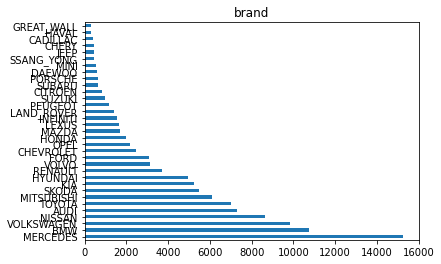

In [32]:
categorical_check('brand')

## color

count     111264
unique        32
top       040001
freq       20905
Name: color, dtype: object

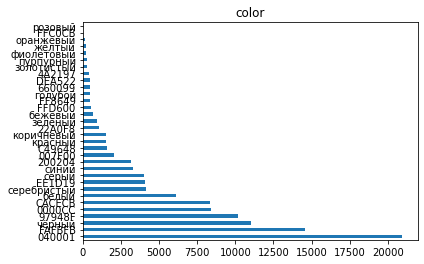

In [33]:
categorical_check('color')

In [34]:
# Есть названия цвета как в формате hex, так и в естественном формате, воспользуемся Figma для определения цветов
df.color.unique()

array(['660099', '0000CC', '040001', 'CACECB', 'FAFBFB', '97948F',
       'EE1D19', 'C49648', '007F00', '22A0F8', '200204', 'DEA522',
       'FF8649', 'FFD600', '4A2197', 'FFC0CB', 'синий', 'чёрный', 'серый',
       'коричневый', 'белый', 'пурпурный', 'бежевый', 'серебристый',
       'красный', 'зелёный', 'жёлтый', 'голубой', 'оранжевый',
       'фиолетовый', 'золотистый', 'розовый'], dtype=object)

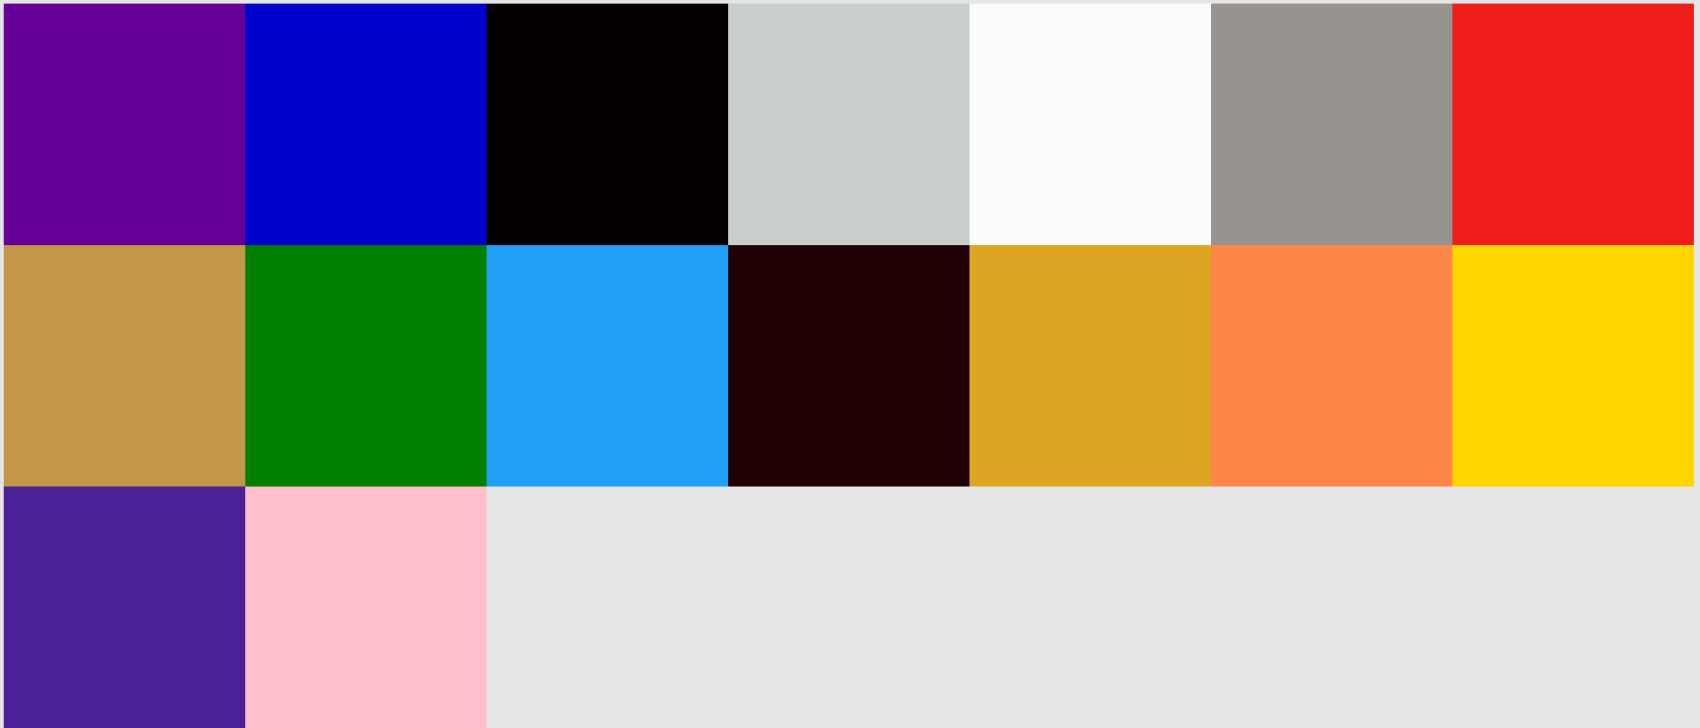

In [35]:
color = {'660099': 'фиолетовый', '0000CC': 'синий', '040001': 'чёрный', 'CACECB': 'серебристый',
         'FAFBFB': 'белый', '97948F': 'серый', 'EE1D19': 'красный', 'C49648': 'коричневый', 
         '007F00': 'зелёный', '22A0F8': 'голубой', '200204': 'чёрный', 'DEA522': 'золотистый',
         'FF8649': 'оранжевый', 'FFD600': 'жёлтый', '4A2197': 'пурпурный', 'FFC0CB': 'розовый',
         'синий': 'синий', 'чёрный': 'чёрный', 'серый': 'серый', 'коричневый': 'коричневый',
         'белый': 'белый', 'пурпурный': 'пурпурный', 'бежевый': 'бежевый', 'серебристый': 'серебристый',
         'красный': 'красный', 'зелёный': 'зелёный', 'жёлтый': 'жёлтый', 'голубой': 'голубой',
         'оранжевый': 'оранжевый', 'фиолетовый':'фиолетовый', 'золотистый':'золотистый',
         'розовый': 'розовый'}
df['color'] = df['color'].map(color)

count     111264
unique        16
top       чёрный
freq       35089
Name: color, dtype: object

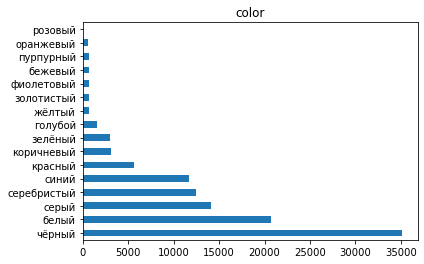

In [36]:
categorical_check('color')

## fuelType

count     111264
unique         7
top       бензин
freq       90921
Name: fuelType, dtype: object

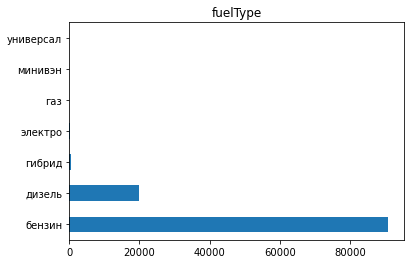

In [37]:
categorical_check('fuelType')

In [38]:
# присутствуют ошибки заполнения, заменим на самое популярное
fuel = {'бензин': 'бензин', 'дизель': 'дизель', 'гибрид': 'гибрид', 'электро': 'электро',
        'газ': 'газ', 'минивэн': 'бензин', 'универсал': 'бензин'}
df['fuelType'] = df['fuelType'].map(fuel)

## modelDate

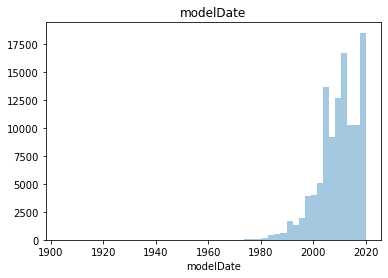

count    111262.000000
mean       2009.606523
std           7.822772
min        1904.000000
25%        2006.000000
50%        2011.000000
75%        2016.000000
max        2020.000000
Name: modelDate, dtype: float64

In [39]:
numerical_check('modelDate')

In [40]:
# два пропуска заменим средним значением
df.modelDate.fillna(2009, inplace=True)

## name

count                111262
unique                 4506
top       2.0 AT (150 л.с.)
freq                   1737
Name: name, dtype: object

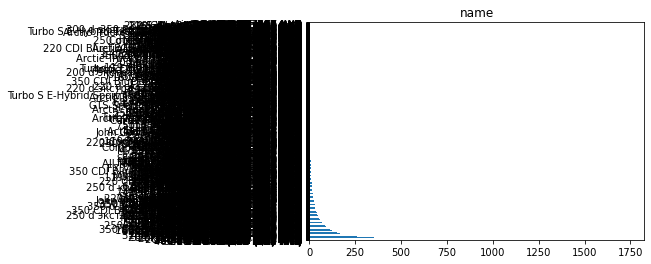

In [41]:
categorical_check('name')

In [42]:
# Данный признак используется в обработке другого, потом удалим

## numberOfDoors

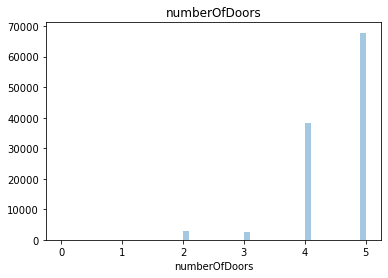

count    111262.00000
mean          4.53658
std           0.66782
min           0.00000
25%           4.00000
50%           5.00000
75%           5.00000
max           5.00000
Name: numberOfDoors, dtype: float64

In [43]:
numerical_check('numberOfDoors')

In [44]:
# Заполним пропуски самым популярным значением
df.numberOfDoors.fillna(5.0, inplace=True)

## productionDate

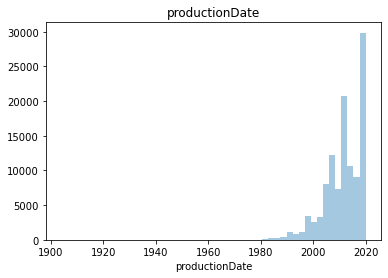

count    111264.000000
mean       2011.736510
std           7.349025
min        1904.000000
25%        2008.000000
50%        2013.000000
75%        2018.000000
max        2020.000000
Name: productionDate, dtype: float64

In [45]:
numerical_check('productionDate')

## vehicleConfiguration

count                            111262
unique                             1878
top       ALLROAD_5_DOORS AUTOMATIC 2.0
freq                               4573
Name: vehicleConfiguration, dtype: object

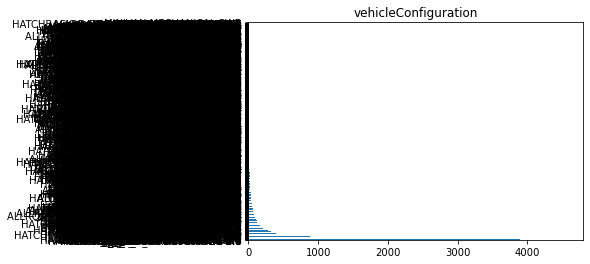

In [46]:
categorical_check('vehicleConfiguration')

In [47]:
# в признаке дублируется информация, можно удалить
df.drop('vehicleConfiguration', axis=1, inplace=True)

## vehicleTransmission

count        111262
unique            8
top       AUTOMATIC
freq          42747
Name: vehicleTransmission, dtype: object

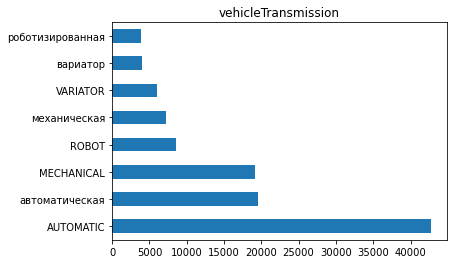

In [48]:
categorical_check('vehicleTransmission')

In [49]:
# приведем к общему формату данных
transmission = {'AUTOMATIC': 'AUTOMATIC', 'автоматическая': 'AUTOMATIC',
                'MECHANICAL': 'MECHANICAL', 'механическая': 'MECHANICAL', 
                'ROBOT': 'ROBOT', 'роботизированная': 'ROBOT', 
                'VARIATOR': 'VARIATOR', 'вариатор': 'VARIATOR'}
df['vehicleTransmission'] = df['vehicleTransmission'].map(transmission)
df.vehicleTransmission.fillna('AUTOMATIC', inplace=True)

count        111264
unique            4
top       AUTOMATIC
freq          62345
Name: vehicleTransmission, dtype: object

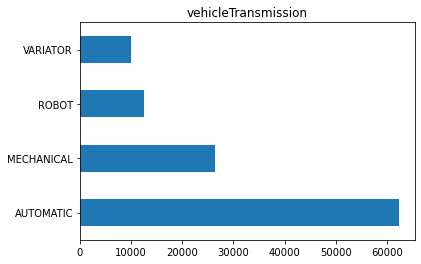

In [50]:
categorical_check('vehicleTransmission')

## engineDisplacement

count     111262
unique       539
top          1.6
freq       13834
Name: engineDisplacement, dtype: object

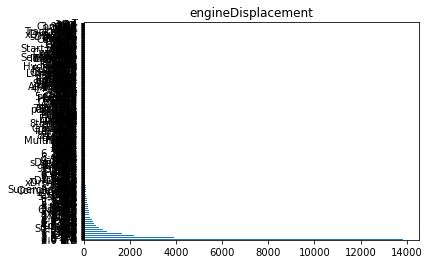

In [51]:
categorical_check('engineDisplacement')

In [52]:
df.engineDisplacement.sample(10)

70226         200
91296     5.0 LTR
104995    1.6 LTR
66878         280
92404     3.0 LTR
45831        1.5d
108636    2.0 LTR
14587         1.5
1433           45
62850        2.4d
Name: engineDisplacement, dtype: object

In [53]:
# значение объема в литрах было также в признаке name, возьмем значение от туда
df['engineDisplacement'] = df['name'].apply(engine_to_liter)

In [54]:
df.drop('name', axis=1, inplace=True)

In [55]:
# есть 159 пропусков
# в электрокары подставим значения по паспорту, а в остальные подставим среднее значение
df.engineDisplacement.loc[df['model'] == 'E_TRON'] = 0
df.engineDisplacement.loc[df['model'] == 'I3'] = 0.6
df.engineDisplacement.loc[df['model'] == 'BOLT'] = 0
df.engineDisplacement.loc[df['model'] == 'LEAF'] = 0
df.engineDisplacement.loc[df['model'] == 'TAYCAN'] = 0
df.engineDisplacement.loc[df['model'] == 'TWIZY'] = 0
df.engineDisplacement.fillna(1.6, inplace=True)

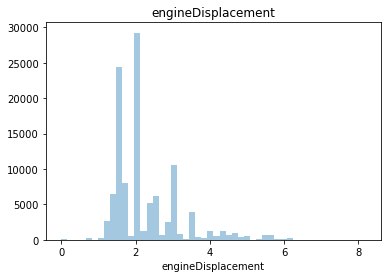

count    111264.000000
mean          2.262683
std           0.903653
min           0.000000
25%           1.600000
50%           2.000000
75%           2.500000
max           8.200000
Name: engineDisplacement, dtype: float64

In [56]:
numerical_check('engineDisplacement')

In [57]:
outliers('engineDisplacement')

col: engineDisplacement 
left: 0.2500000000000002 
right: 3.8499999999999996 
out: 7668


In [58]:
#имеются выбросы, когда буду тестировать модели, проверю их влияние

## enginePower

count     111262.0
unique       690.0
top          150.0
freq        7725.0
Name: enginePower, dtype: float64

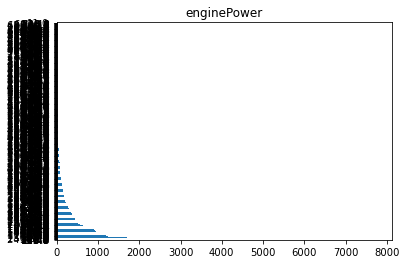

In [59]:
categorical_check('enginePower')

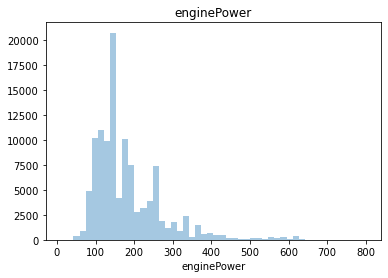

count    111262.000000
mean        181.889405
std          90.236503
min          11.000000
25%         122.000000
50%         150.000000
75%         220.000000
max         800.000000
Name: enginePower, dtype: float64

In [60]:
# обработаем и приведем к числам
df = df[df['enginePower'].notna()]
df.loc[df['Train']==0, 'enginePower'] = df[df['Train']==0]['enginePower'].apply(lambda x: int(x.split()[0]))
df['enginePower'] = df['enginePower'].astype('int64')
numerical_check('enginePower')

## description

In [61]:
df.description[0]
# По хорошему нужно провести анализ описаний, но за отсутствием времени, просто удалю признак

'Автомобиль в хорошем состоянии кому интересно позвоните \nТорг есть WAUZZZ4AZMN025391 для проверки '

In [62]:
df.drop('description', axis=1, inplace=True)

## mileage

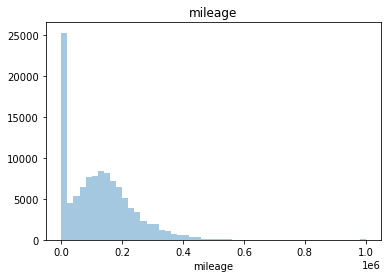

count     111262.000000
mean      124781.415038
std       106323.059820
min            0.000000
25%        31756.500000
50%       116000.000000
75%       187000.000000
max      1000000.000000
Name: mileage, dtype: float64

In [63]:
numerical_check('mileage')

In [64]:
outliers('mileage')
# есть выбросы, пкоа оставим

col: mileage 
left: -201108.75 
right: 419865.25 
out: 1257


## Привод

count       111262
unique           3
top       передний
freq         52894
Name: Привод, dtype: object

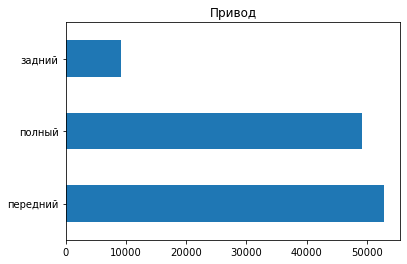

In [65]:
categorical_check('Привод')

## Руль

count     111262
unique         4
top         LEFT
freq       75337
Name: Руль, dtype: object

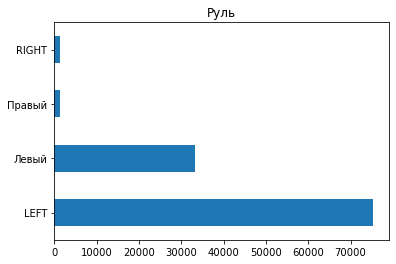

In [66]:
categorical_check('Руль')

In [67]:
# Согласуем данные
wheel = {'RIGHT': 'RIGHT', 'Правый': 'RIGHT',
         'LEFT': 'LEFT', 'Левый': 'LEFT'}
df['Руль'] = df['Руль'].map(wheel)

## Состояние

count                  34686
unique                     1
top       Не требует ремонта
freq                   34686
Name: Состояние, dtype: object

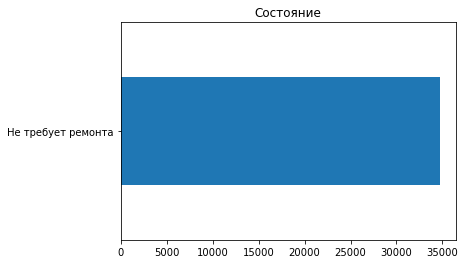

In [68]:
categorical_check('Состояние')

In [69]:
# Парсинг не смог дотстать данные, поэтому данный признак удалим
df.drop('Состояние', axis=1, inplace=True)

## Владельцы

count     89728.0
unique        6.0
top           3.0
freq      23318.0
Name: Владельцы, dtype: float64

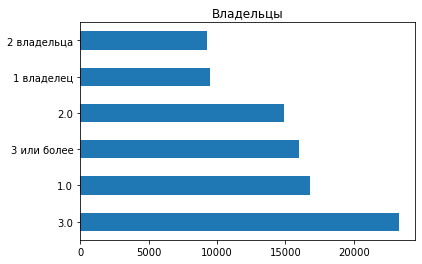

In [70]:
categorical_check('Владельцы')

In [71]:
# для начала согласуем
owner = {'3 или более': 3, 3.0: 3, '2 владельца': 2, 2.0: 2, '1 владелец': 1,
         1.0: 1}
df['Владельцы'] = df['Владельцы'].map(owner)

count    70999.000000
mean         2.316131
std          0.830839
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          3.000000
Name: Владельцы, dtype: float64

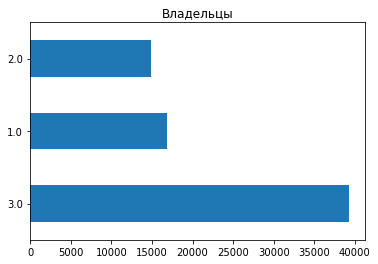

In [72]:
categorical_check('Владельцы')

In [73]:
# Для начала заполним 0 где пробег составляет <100, т.е. новые машины из салона
len(df[(df.Владельцы.isna()) & (df.mileage == 0)])

21534

In [74]:
mask_own_1 = (df.Владельцы.isna()) & (df.mileage < 100)
df.loc[mask_own_1, 'Владельцы'] = df.loc[mask_own_1, 'Владельцы'].fillna(0)

In [75]:
df[(df.Владельцы == 1) & (df.mileage > 100)].mileage.describe()

count      16660.000000
mean       96569.288055
std        72477.655718
min          101.000000
25%        43207.500000
50%        83000.000000
75%       132394.250000
max      1000000.000000
Name: mileage, dtype: float64

In [76]:
df[(df.Владельцы == 2) & (df.mileage > 100)].mileage.describe()

count      14891.000000
mean      142006.689544
std        80961.233924
min          119.000000
25%        86481.500000
50%       130000.000000
75%       181235.000000
max      1000000.000000
Name: mileage, dtype: float64

In [77]:
df[(df.Владельцы == 3) & (df.mileage > 100)].mileage.describe()

count      39263.000000
mean      199326.348089
std        95879.596864
min          108.000000
25%       135000.000000
50%       183114.000000
75%       250000.000000
max      1000000.000000
Name: mileage, dtype: float64

In [78]:
# оставшиеся пропуски заполним по пробегу
mask_own_2 = (df.Владельцы.isna()) & (df.mileage <= 83000)
df.loc[mask_own_1, 'Владельцы'] = df.loc[mask_own_1, 'Владельцы'].fillna(1)

mask_own_3 = (df.Владельцы.isna()) & (df.mileage <= 130000)
df.loc[mask_own_1, 'Владельцы'] = df.loc[mask_own_1, 'Владельцы'].fillna(2)

df.Владельцы.fillna(3, inplace=True)

## ПТС

count       110713
unique           4
top       ORIGINAL
freq         69064
Name: ПТС, dtype: object

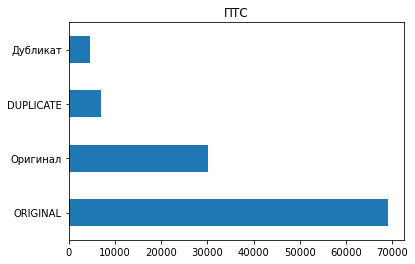

In [79]:
categorical_check('ПТС')

In [80]:
# Приведем к единому формату
pts = {'ORIGINAL': 'ORIGINAL', 'Оригинал': 'ORIGINAL', 
       'DUPLICATE': 'DUPLICATE', 'Дубликат': 'DUPLICATE'}
df['ПТС'] = df['ПТС'].map(pts)

In [81]:
df[(df['ПТС'].isna()) & (df.mileage < 100)]
# пропуски в основном у новых авто из салона, доверимся салону и заменим пропуски на Оригинал

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,mileage,Привод,Руль,Владельцы,ПТС,Таможня,Владение,price,model,Train
271,седан,AUDI,синий,бензин,2016.0,4.0,2020,ROBOT,1.4,150,0,передний,LEFT,0.0,NaN,Растаможен,NaN,1950000.0,A3,1
872,седан,AUDI,синий,бензин,2019.0,4.0,2020,ROBOT,2.0,249,0,полный,LEFT,0.0,NaN,Растаможен,NaN,3400000.0,A4,1
874,седан,AUDI,синий,бензин,2019.0,4.0,2020,ROBOT,2.0,150,0,передний,LEFT,0.0,NaN,Растаможен,NaN,3175000.0,A4,1
877,седан,AUDI,серый,бензин,2019.0,4.0,2020,ROBOT,2.0,150,0,передний,LEFT,0.0,NaN,Растаможен,NaN,3175000.0,A4,1
878,седан,AUDI,чёрный,бензин,2019.0,4.0,2020,ROBOT,2.0,190,0,передний,LEFT,0.0,NaN,Растаможен,NaN,2900000.0,A4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73528,внедорожник 5 дв.,MERCEDES,чёрный,дизель,2019.0,5.0,2020,AUTOMATIC,2.9,330,0,полный,LEFT,0.0,NaN,Растаможен,NaN,8250000.0,GLS_KLASSE,1
74660,внедорожник 5 дв.,MERCEDES,чёрный,бензин,2019.0,5.0,2020,AUTOMATIC,4.0,558,0,полный,LEFT,0.0,NaN,Растаможен,NaN,24589000.0,MAYBACH_GLS,1
75802,минивэн l,MERCEDES,чёрный,дизель,2014.0,5.0,2020,AUTOMATIC,2.1,190,0,полный,LEFT,0.0,NaN,Растаможен,NaN,18990000.0,V_KLASSE,1
75806,минивэн xl,MERCEDES,чёрный,дизель,2014.0,5.0,2020,AUTOMATIC,2.1,190,0,полный,LEFT,0.0,NaN,Растаможен,NaN,18215000.0,V_KLASSE,1


In [82]:
df.ПТС.fillna('ORIGINAL', inplace=True)

## Таможня

count         111262
unique             1
top       Растаможен
freq          111262
Name: Таможня, dtype: object

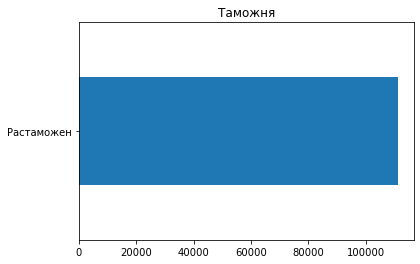

In [83]:
categorical_check('Таможня')
# видим одно значение, признак можно удалитьб

In [84]:
df.drop('Таможня', axis=1, inplace=True)

## Владение

count                           29039
unique                            561
top       {'year': 2018, 'month': 12}
freq                              296
Name: Владение, dtype: object

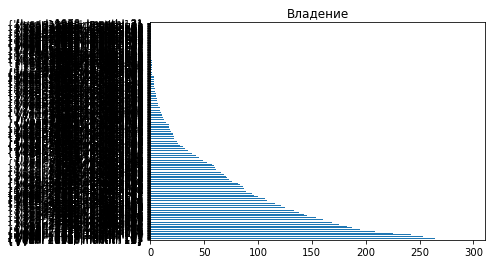

In [85]:
categorical_check('Владение')

In [86]:
# Важный признак, но очень много пропусков, поэтому придется удалить
df.drop('Владение', axis=1, inplace=True)

## price

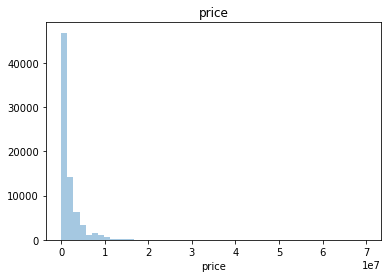

count    7.631300e+04
mean     1.955611e+06
std      2.673396e+06
min      2.500000e+04
25%      4.800000e+05
50%      1.001607e+06
75%      2.240000e+06
max      6.990000e+07
Name: price, dtype: float64

In [87]:
numerical_check('price')

In [88]:
len(df[(df['Train']==1) & (df['price'].isna())])

263

In [89]:
df = df[((df['Train']==1)&(df['price'].notna())) | (df['Train']==0)]

## model

count      110999
unique       1028
top       OCTAVIA
freq         2529
Name: model, dtype: object

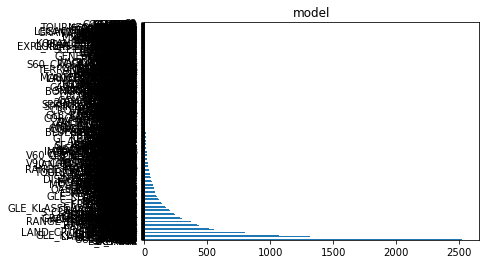

In [90]:
categorical_check('model')

# Новые признаки

## log

In [91]:
# В первую очередб прологарифмируем
df['modelDate_log'] = np.log(df['modelDate'] + 1)
df['productionDate_log'] = np.log(df['productionDate'] + 1)
df['engineDisplacement_log'] = np.log(df['engineDisplacement'] + 1)
df['enginePower_log'] = np.log(df['enginePower'] + 1)
df['mileage_log'] = np.log(df['mileage'] + 1)

## Salon

In [92]:
# добавим признак салон, который обозначет продается машина в салоне или нет
df['salon'] = df.apply(lambda x: 1 if x['mileage'] < 100 else 0, axis=1)

## pop_model

In [93]:
# Возьмем маркер топ 100 моделей
top_100 = list(pd.DataFrame(df.model.value_counts()).index[:100])
df['top_100'] = df.model.apply(get_pop_100)

## pop_brand

In [94]:
# Возьмем маркер топ 10 брендов
top_10 = list(pd.DataFrame(df.brand.value_counts()).index[:10])
df['top_10'] = df.brand.apply(get_pop_10)

# Анализ данных

In [95]:
# удалим обычные признаки
df.drop(['modelDate', 'productionDate', 'engineDisplacement', 'enginePower', 'mileage'], axis=1, inplace=True)
# распределим признаки по типу
# бинарные переменные (5)
bin_cols = ['Руль', 'ПТС','salon', 'top_100', 'top_10']
# категориальные переменные (8)
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission',
            'Привод', 'model', 'Владельцы']
# числовые переменные (7)
num_cols = ['numberOfDoors', 'price', 'modelDate_log', 'productionDate_log',
            'engineDisplacement_log', 'enginePower_log', 'mileage_log']

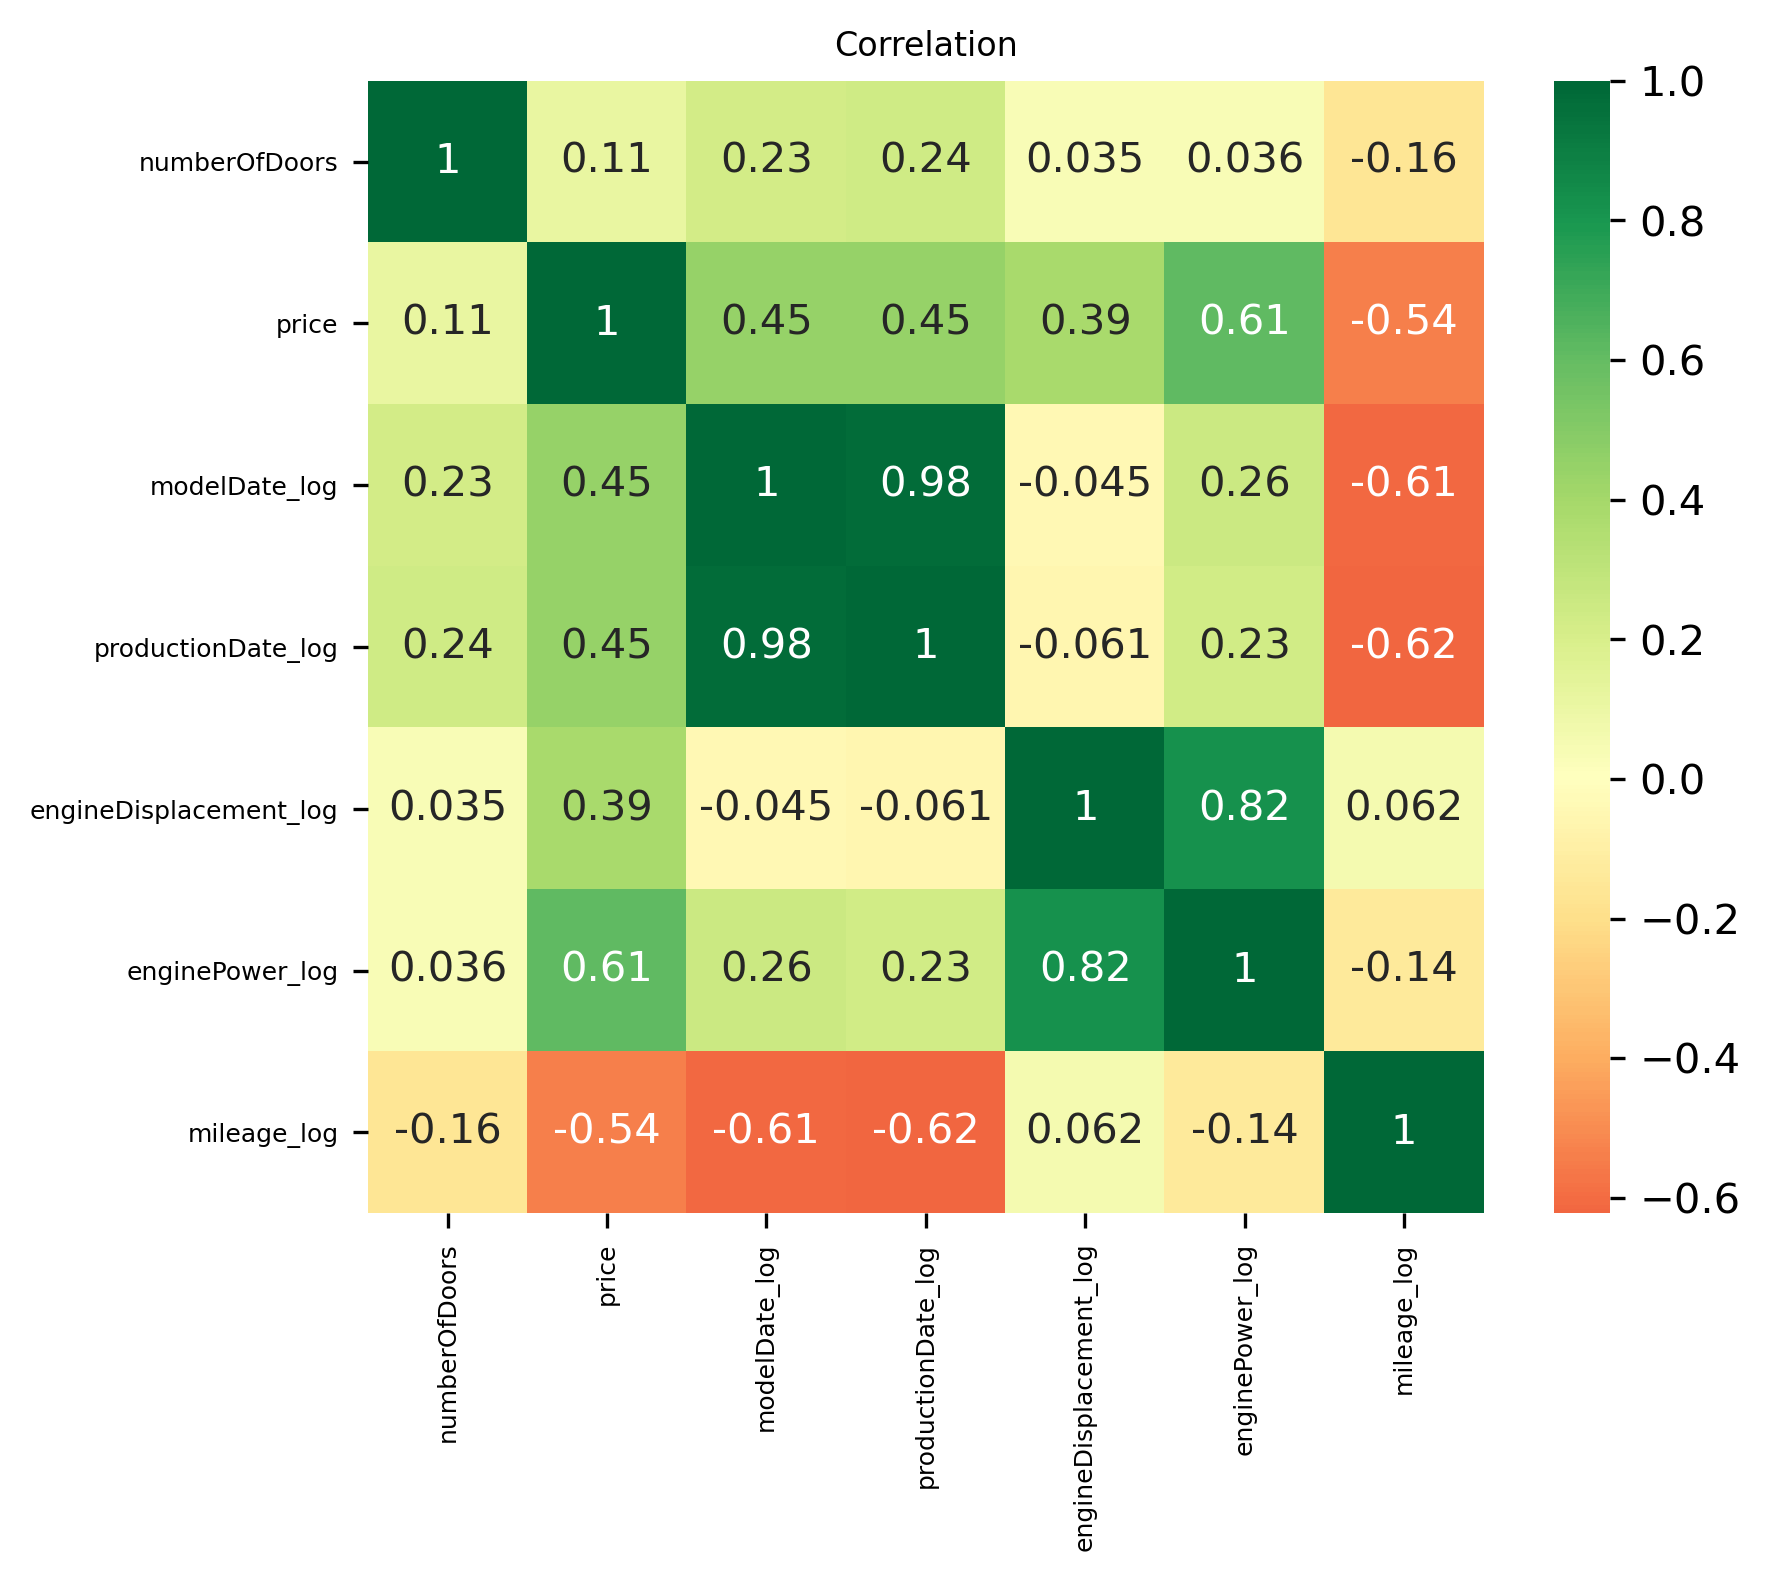

In [96]:
get_corr(df, num_cols)

In [97]:
# #Есть сильно коррелирующие признаки между собой, удалим
# df.drop(['productionDate_log', 'engineDisplacement_log'], axis=1, inplace=True)

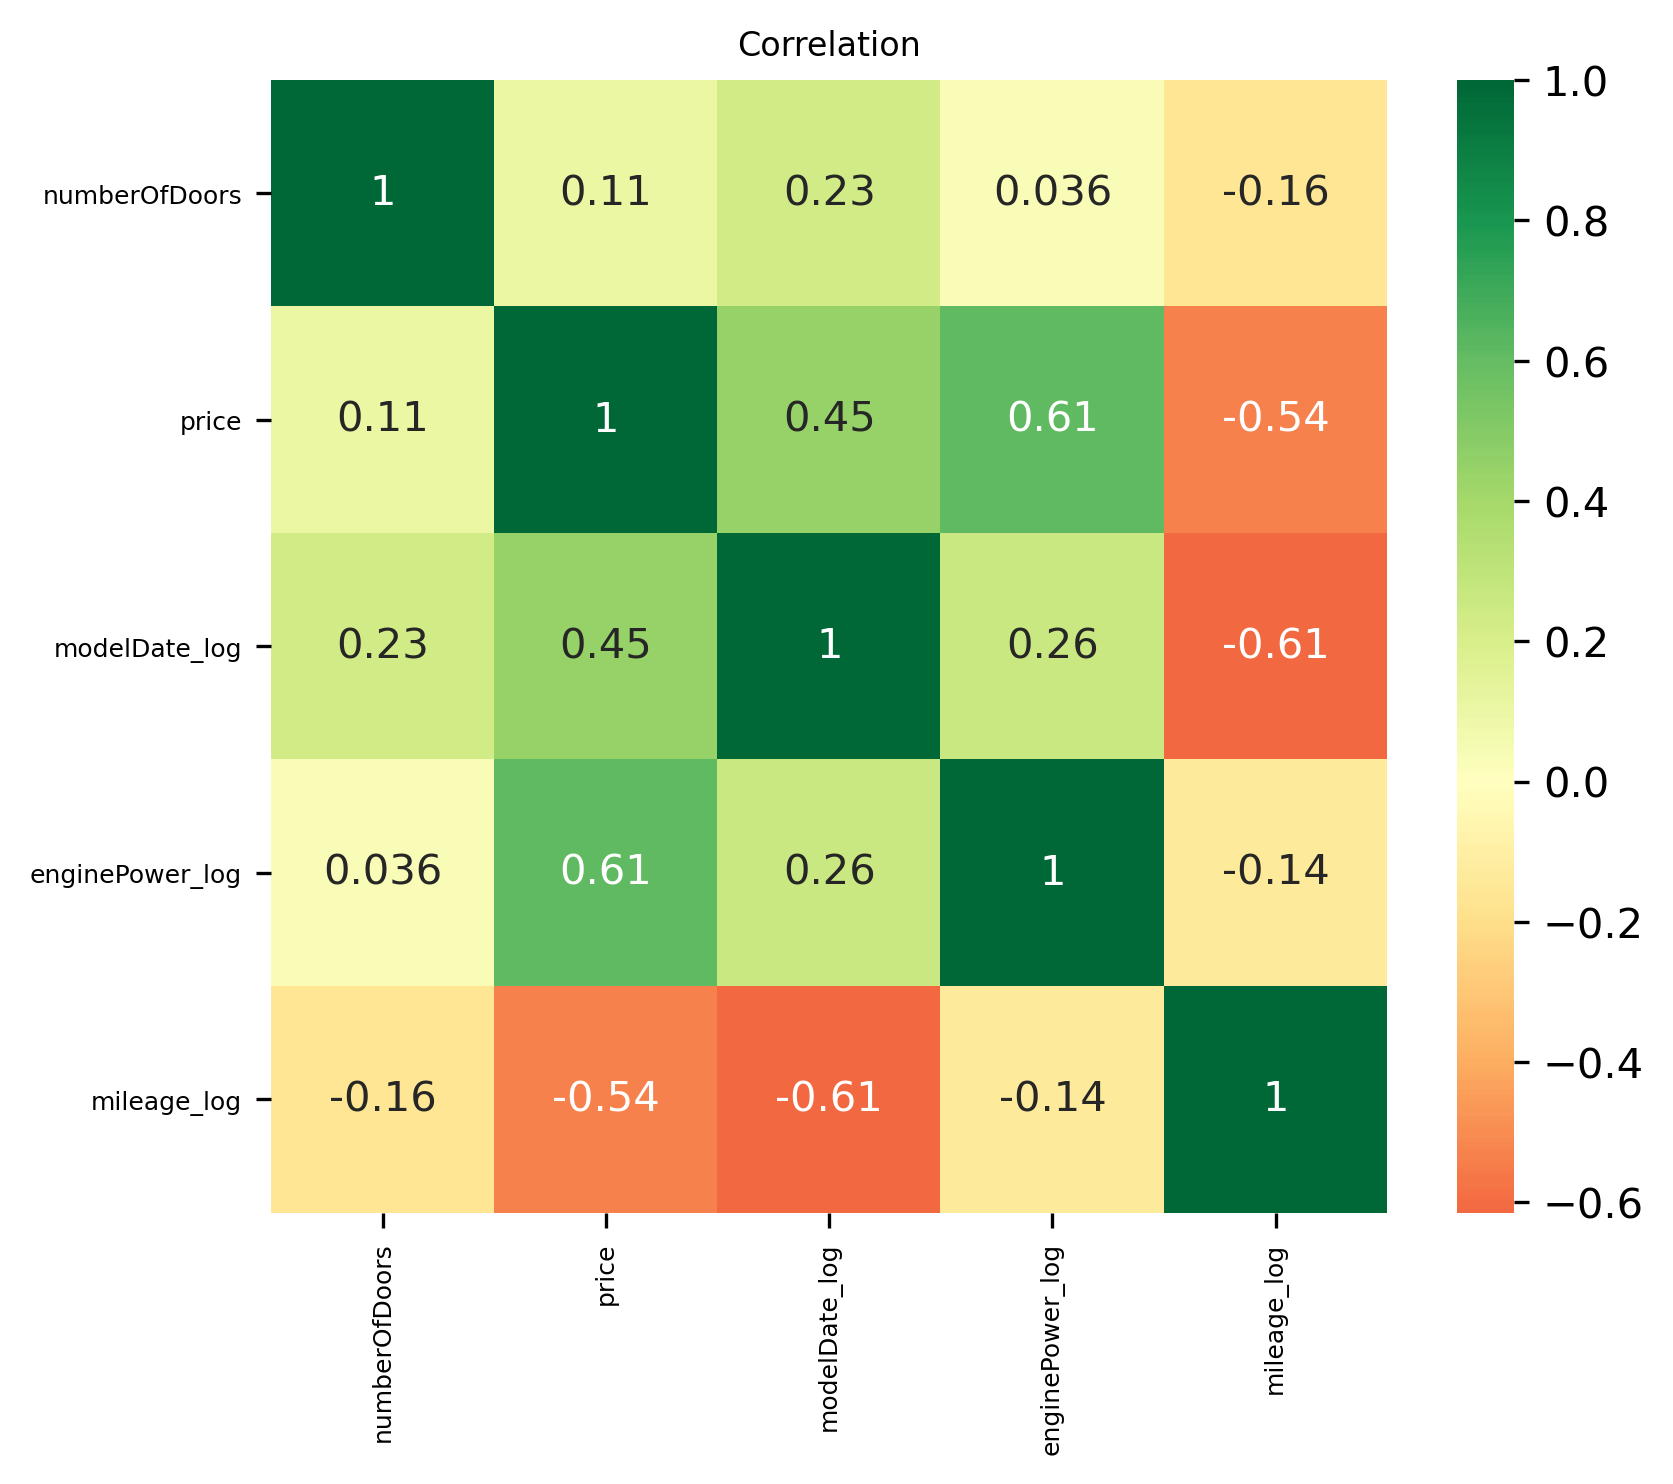

In [98]:
num_cols = ['numberOfDoors', 'price', 'modelDate_log', 'enginePower_log', 'mileage_log']
get_corr(df, num_cols)

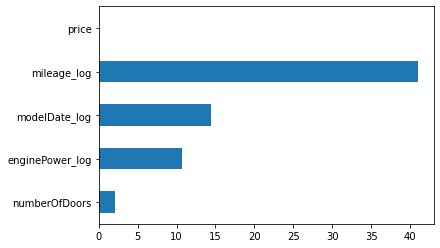

In [99]:
test_df = df[df['Train']==1]
imp_num = Series(f_classif(test_df[num_cols], test_df['price'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [100]:
# самый важный признак километраж
del test_df

update.   
В итоге получил супер переобученную модель, но времени исправить совсем нет....  
Поэтому пробую "колхозным" методом

In [101]:
# Обработаем бинарные признаки, а также сформируем dummy признаки 
label_encoder = LabelEncoder()


for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

# df_d = pd.get_dummies(df, columns=cat_cols, dummy_na=False)

# # теперь создадим список дамми переменных
# df_cols = list(df.columns)
# df_d_cols = list(df_d.columns)
# dumm_cols= list(set(df_d_cols)-set(df_cols ))

# df_d.head(2)

In [102]:
for column in cat_cols:
    df[column] = label_encoder.fit_transform(df[column])

In [103]:
df

,bodyType,brand,color,fuelType,numberOfDoors,vehicleTransmission,Привод,Руль,Владельцы,ПТС,...,model,Train,modelDate_log,productionDate_log,engineDisplacement_log,enginePower_log,mileage_log,salon,top_100,top_10
0,89,0,14,0,4.0,1,2,0,1,1,...,1,1,7.596392,7.596894,1.335001,5.164786,12.429220,0,0,1
1,89,0,13,0,4.0,1,1,0,2,1,...,1,1,7.596392,7.597898,1.193922,4.897840,13.039466,0,0,1
2,89,0,15,0,4.0,1,1,0,3,1,...,1,1,7.596392,7.596894,1.193922,4.897840,12.736704,0,0,1
3,89,0,11,0,4.0,0,1,0,3,0,...,1,1,7.596392,7.597396,1.193922,4.897840,12.676079,0,0,1
4,89,0,15,0,4.0,1,1,0,3,1,...,1,1,7.596392,7.596894,1.193922,4.897840,9.210440,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111259,89,1,6,0,4.0,0,0,0,3,1,...,40,0,7.606885,7.608374,0.955511,4.919981,11.652696,0,1,1
111260,89,1,15,3,4.0,0,2,0,3,1,...,55,0,7.609367,7.610358,1.098612,5.252273,11.492733,0,1,1
111261,89,1,12,0,4.0,0,0,0,3,0,...,55,0,7.598900,7.599902,1.252763,5.141664,12.793862,0,1,1
111262,3,1,6,3,5.0,0,2,0,3,1,...,989,0,7.607381,7.607878,1.098612,5.220356,11.413116,0,1,1


In [104]:
# # Тест Стьюдента
# st_cols = []
# temp_df = df_d[(df['Train']==1)]
# for col in bin_cols+dumm_cols:
#     st_cols.append(get_stat_dif(col,temp_df))
# st_cols = list(filter(None, st_cols))

In [105]:
# left_st_cols=list(set(bin_cols+dumm_cols) - set(st_cols))
# print(f'Тест Стьюдента показал {len(left_st_cols)} признаков которые не важны')

In [106]:
# df_d.drop(left_st_cols, axis=1, inplace=True)
# df_d.head(2)

# Подготовка данных для модели¶

In [107]:
# разделяем датасет на тренировочный и тестовый
train_df = df.query('Train == 1').drop('Train', axis=1)
test_df = df.query('Train == 0').drop('Train', axis=1)
del df
#del df_d

In [108]:
X = train_df.drop('price', axis=1)
y = train_df['price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=RANDOM_SEED)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Построение модели

In [109]:
model_1 = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1)
model_1.fit(X_train, np.log(y_train))

model_1_metrics = model_metrics(model_1, 'RForest')
model_1_metrics

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


,RForest
MAPE,12.8


In [110]:
model_2 = LinearRegression()
model_2.fit(X_train, np.log(y_train))

model_2_metrics = model_metrics(model_2, 'LinearR')
models = model_1_metrics
models['LR'] = model_2_metrics
models

,RForest,LR
MAPE,12.8,27.21


In [111]:
model_3 = ExtraTreeRegressor(random_state = RANDOM_SEED)
model_3.fit(X_train, np.log(y_train))

model_3_metrics = model_metrics(model_3, 'EForest')
models['EForest'] = model_3_metrics
models

,RForest,LR,EForest
MAPE,12.8,27.21,19.0


In [112]:
model_4 = GradientBoostingRegressor(n_estimators=500)
model_4.fit(X_train, np.log(y_train))

model_4_metrics = model_metrics(model_4, 'GradBoost')
models['GradBoost'] = model_4_metrics
models

,RForest,LR,EForest,GradBoost
MAPE,12.8,27.21,19.0,22.03


In [113]:
model_5 = BaggingRegressor(model_1, n_estimators=3, n_jobs=-1, random_state=RANDOM_SEED)
model_5.fit(X_train, np.log(y_train))

model_5_metrics = model_metrics(model_5, 'Bagging')
models['Bagging'] = model_5_metrics
models

,RForest,LR,EForest,GradBoost,Bagging
MAPE,12.8,27.21,19.0,22.03,12.61


In [114]:
model_6 = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )                    
                           
model_6.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model_6_metrics = model_metrics(model_6, 'CatBoost')
models['CatBoost'] = model_6_metrics
models

,RForest,LR,EForest,GradBoost,Bagging,CatBoost
MAPE,12.8,27.21,19.0,22.03,12.61,14.13


In [115]:
# model_7 = KNeighborsRegressor(n_jobs=-1, n_neighbors=2)
# model_7.fit(X_train, np.log(y_train))

# model_7_metrics = model_metrics(model_7, 'KNN')
# models['KNN'] = model_7_metrics
# models

Алгоритм KNN кушает очень много RAM, поэтому я его закомментил, но результат выдает следующий:
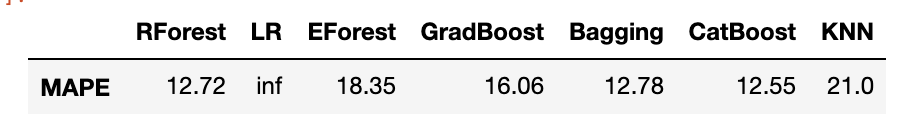

Также сначала проверял модели без логарифмирования целевой переменной, вот скрин без:  
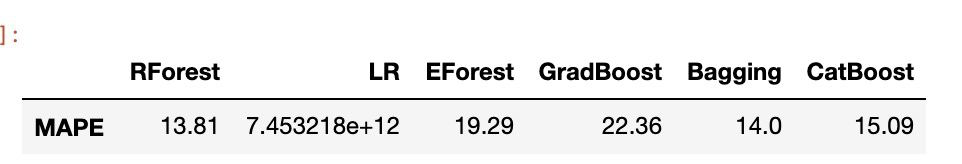

## Подбор параметров моделей

In [116]:
# np.random.seed(42)

# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 50)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# rf = RandomForestRegressor()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
#                                n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(X_train, np.log(y_train))
# # Оптимальные гиперпараметры:
# rf_random.best_params_

Тот случай, когда он считал 451 мин и не вывел параметры...
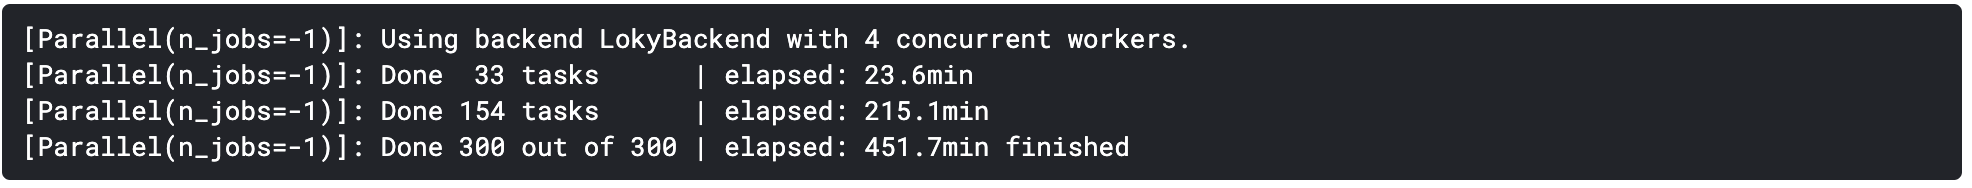
Поэтому параметры ниже я сидел и в ручную перебирал

In [117]:
model_8 = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1,
                                n_estimators=400, min_samples_split=5, min_samples_leaf=1,
                                max_features=10, max_depth=50, bootstrap=True)
model_8.fit(X_train, np.log(y_train))

model_8_metrics = model_metrics(model_8, 'RForest+')
models['RForest+'] = model_8_metrics
models

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   24.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.7s finished


,RForest,LR,EForest,GradBoost,Bagging,CatBoost,RForest+
MAPE,12.8,27.21,19.0,22.03,12.61,14.13,12.04


In [118]:
model_9 = BaggingRegressor(model_8, n_estimators=5, n_jobs=-1, random_state=RANDOM_SEED)
model_9.fit(X_train, np.log(y_train))

model_9_metrics = model_metrics(model_9, 'Bagging+')
models['Bagging+'] = model_9_metrics
models

,RForest,LR,EForest,GradBoost,Bagging,CatBoost,RForest+,Bagging+
MAPE,12.8,27.21,19.0,22.03,12.61,14.13,12.04,12.14


In [119]:
model_10 = CatBoostRegressor(iterations = 10000, random_seed = RANDOM_SEED,
                             learning_rate = 0.05, eval_metric='MAPE',
                             custom_metric=['RMSE'])                     
                           
model_10.fit(X_train, np.log(y_train), eval_set=(X_test, np.log(y_test)),
             verbose_eval=100, use_best_model=True)

model_10_metrics = model_metrics(model_10, 'CatBoost+')
models['CatBoost+'] = model_10_metrics
models

0:	learn: 0.0629273	test: 0.0627713	best: 0.0627713 (0)	total: 13.8ms	remaining: 2m 18s
100:	learn: 0.0131773	test: 0.0134464	best: 0.0134464 (100)	total: 1.11s	remaining: 1m 48s
200:	learn: 0.0115770	test: 0.0120264	best: 0.0120264 (200)	total: 2.25s	remaining: 1m 49s
300:	learn: 0.0106448	test: 0.0112081	best: 0.0112081 (300)	total: 3.32s	remaining: 1m 47s
400:	learn: 0.0099964	test: 0.0107225	best: 0.0107196 (398)	total: 4.63s	remaining: 1m 50s
500:	learn: 0.0095761	test: 0.0104348	best: 0.0104340 (499)	total: 5.75s	remaining: 1m 48s
600:	learn: 0.0092477	test: 0.0104123	best: 0.0102839 (559)	total: 6.87s	remaining: 1m 47s
700:	learn: 0.0090150	test: 0.0106407	best: 0.0102839 (559)	total: 7.96s	remaining: 1m 45s
800:	learn: 0.0088196	test: 0.0105623	best: 0.0102839 (559)	total: 9s	remaining: 1m 43s
900:	learn: 0.0086538	test: 0.0104694	best: 0.0102839 (559)	total: 10.1s	remaining: 1m 41s
1000:	learn: 0.0085143	test: 0.0103937	best: 0.0102839 (559)	total: 11.2s	remaining: 1m 40s
1100

,RForest,LR,EForest,GradBoost,Bagging,CatBoost,RForest+,Bagging+,CatBoost+
MAPE,12.8,27.21,19.0,22.03,12.61,14.13,12.04,12.14,14.57


## Стекинг

In [120]:
# функции для стекинга
def compute_metric(regr, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    regr.fit(X_train, np.log(y_train))
    y_test_pred = np.exp(regr.predict(X_test))
    return np.round(mape(y_test, y_test_pred)*100, 2)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


def compute_meta_feature2(regr, X_train, X_test, y_train, cv, X_pred):    
    
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)    

    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_regr = clone(regr)
        folded_regr.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)
    
    meta_regr = clone(regr)
    meta_regr.fit(X_train, y_train)
    
    X_meta_test = meta_regr.predict(X_test)
    X_meta_pred = meta_regr.predict(X_pred)
    
    return X_meta_train, X_meta_test, X_meta_pred


def generate_meta_features2(regr_s, X_train, X_test, y_train, cv, X_pred):
   
    features = [compute_meta_feature2(regr, X_train, X_test, y_train, cv, X_pred) for regr in tqdm(regr_s)]    
    stacked_features_train = np.vstack([features_train for features_train, features_test, features_pred in features]).T
    stacked_features_test = np.vstack([features_test for features_train, features_test, features_pred in features]).T
    stacked_features_pred = np.vstack([features_pred for features_train, features_test, features_pred in features]).T
    return stacked_features_train, stacked_features_test, stacked_features_pred

In [121]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
X_pred = X_test

In [122]:
# stacked_features_train, stacked_features_test, stacked_features_pred = generate_meta_features2([
#     model_8, model_10], X_train, X_test, y_train, cv, X_pred)

# regr = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1,
#                                 n_estimators=400, min_samples_split=5, min_samples_leaf=1,
#                                 max_features=150, max_depth=120, bootstrap=True)

# print(f'Stacking MAPE = {compute_metric(regr, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test, y_test=y_test)}%')

С данными моделями результать получить не смог. Да и в целом со стекингом я очень плохо разобрался

# Submission

In [123]:
# X_train = train_df.drop('price', axis=1)
# y_train = train_df['price'].values
# X_test = test_df.drop('price', axis=1)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

# model = CatBoostRegressor(iterations = 10000, random_seed = RANDOM_SEED,
#                              learning_rate = 0.05, eval_metric='MAPE',
#                              custom_metric=['RMSE'])                     
                           
# model.fit(X_train, np.log(y_train), verbose_eval=100, use_best_model=True)

In [124]:
X_train = train_df.drop('price', axis=1)
y_train = train_df['price'].values
X_test = test_df.drop('price', axis=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

model = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1,
                                n_estimators=400, min_samples_split=5, min_samples_leaf=1,
                                max_features=10, max_depth=50, bootstrap=True)
model.fit(X_train, np.log(y_train))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   28.6s finished


RandomForestRegressor(max_depth=50, max_features=10, min_samples_split=5,
                      n_estimators=400, n_jobs=-1, random_state=42, verbose=1)

In [125]:
predict_submission = np.round(np.exp(model.predict(X_test)))
VERSION = 6
predict_submission

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    1.0s finished


array([ 930731.,  991862., 1704568., ...,  314749., 2474293., 1334326.])

In [126]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,930731.0
1,1100549428,991862.0
2,1100658222,1704568.0
3,1100937408,925623.0
4,1101037972,1061827.0
5,1100912634,1629746.0
6,1101228730,1262278.0
7,1100165896,539814.0
8,1100768262,1733702.0
9,1101218501,1221112.0
